<a href="https://colab.research.google.com/github/Sham2112/Atlas-Autoencoder/blob/master/AE_3d_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from nn_utils import *


%matplotlib inline

In [0]:
infile = open('all_jets_train_4D_100_percent.pkl', 'rb')
traindata = pickle.load(infile)
infile.close()

In [0]:
infile = open('all_jets_test_4D_100_percent.pkl', 'rb')
testdata = pickle.load(infile)
infile.close()

In [0]:
traindata.head()

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871


In [0]:
#normalizing the data
train_mean = traindata.mean()
train_std = traindata.std()

traindata = (traindata-train_mean)/train_std
testdata = (testdata-train_mean)/train_std

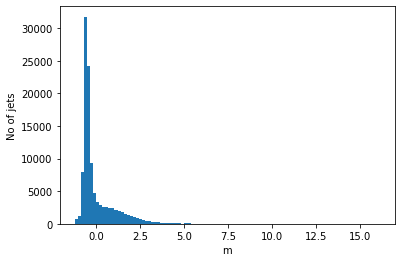

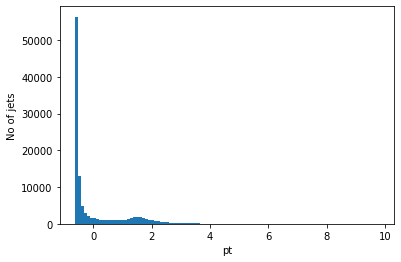

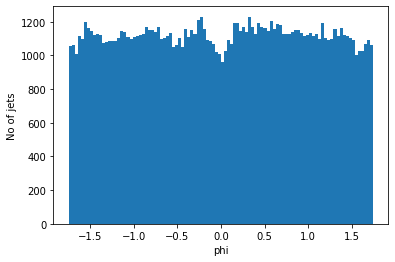

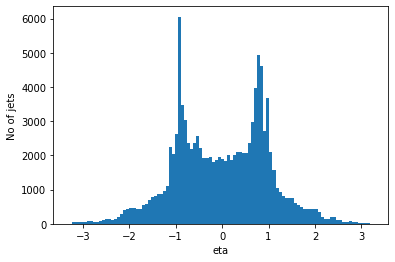

In [0]:
plotdata(traindata)

In [0]:
train_x = traindata
test_x = testdata
train_y = traindata
test_y = testdata

trainset = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
validset = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

In [0]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
validloader = DataLoader(validset, batch_size=32, shuffle=False)

In [0]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Using: ", device)

Using:  cuda


In [0]:
n_epochs = 75
model = AE_3d_200().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [0]:
model, train_losses, valid_losses = fit(n_epochs, criterion, optimizer, model, trainloader, validloader, device)

Epoch: 1, Training loss: 0.06894989144142331, Validation loss: 0.0284406915307045
Validation loss decreased (inf --> 0.0284406915307045).  Saving model ...
Epoch: 2, Training loss: 0.02507051456406175, Validation loss: 0.025255460292100906
Validation loss decreased (0.0284406915307045 --> 0.025255460292100906).  Saving model ...
Epoch: 3, Training loss: 0.02295396428242188, Validation loss: 0.02279066853225231
Validation loss decreased (0.025255460292100906 --> 0.02279066853225231).  Saving model ...
Epoch: 4, Training loss: 0.02073849702919511, Validation loss: 0.02017730101943016
Validation loss decreased (0.02279066853225231 --> 0.02017730101943016).  Saving model ...
Epoch: 5, Training loss: 0.018920766429655237, Validation loss: 0.019289975985884666
Validation loss decreased (0.02017730101943016 --> 0.019289975985884666).  Saving model ...
Epoch: 6, Training loss: 0.01764905996774987, Validation loss: 0.018131962046027184
Validation loss decreased (0.019289975985884666 --> 0.01813

In [0]:
torch.save(model.state_dict(), 'model0.pt')

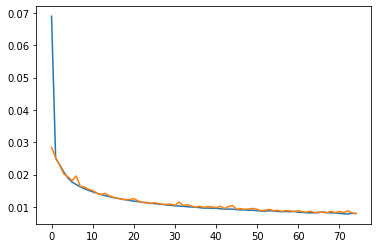

In [0]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

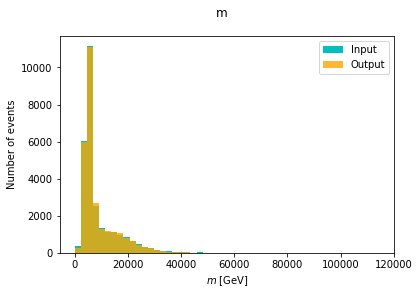

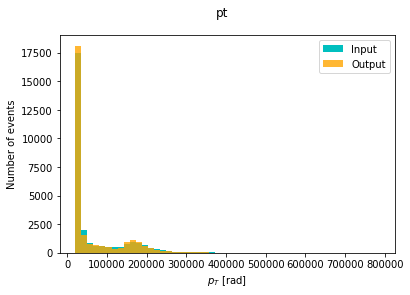

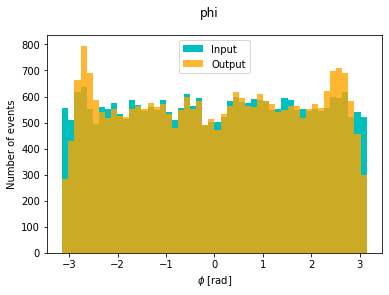

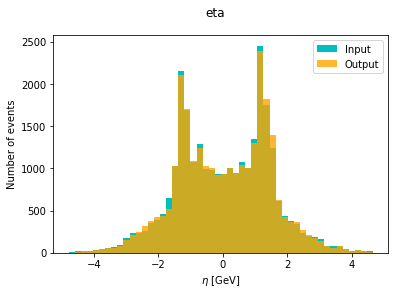

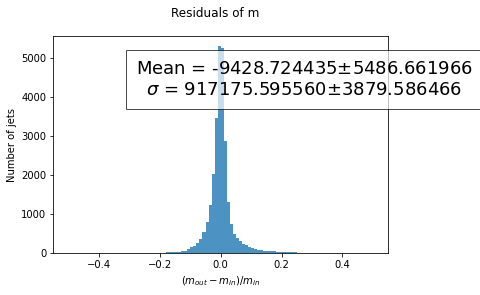

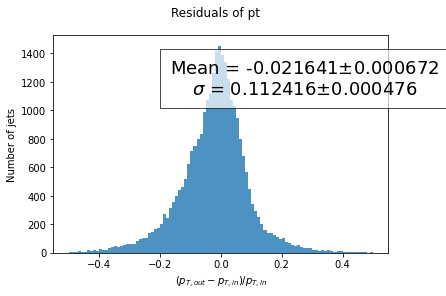

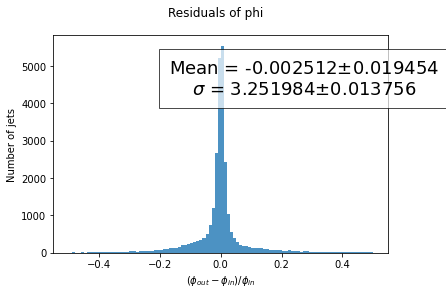

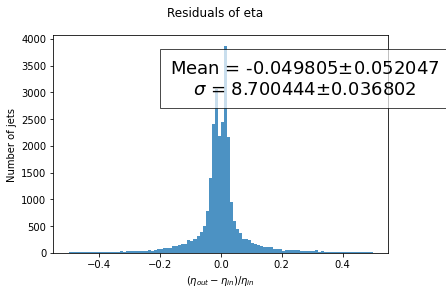

In [0]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = (torch.tensor(test_x[idxs[0]:idxs[1]].values).float())
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % traindata.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

range = (-0.5,0.5)
residual_strings = [r'$(m_{out} - m_{in})/m_{in}$',
                    r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                    r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                    r'$(\eta_{out} - \eta_{in}) / \eta_{in}$'
                    ]


residuals = (pred - data.detach().numpy()) / data.detach().numpy()
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % traindata.columns[kk])
    plt.xlabel(residual_strings[kk])  
    plt.ylabel('Number of jets')
    std = np.std(residuals[:, kk])
    std_err = std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % traindata.columns[kk]

In [0]:
#We see that most of the residuals are within 0.5%
#We will now obsereve the results after custom normalization